<a href="https://colab.research.google.com/github/hayya54/UAS_BPDAL/blob/main/FP_BDPAL_DiabetesClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Final Project BDPAL Kelompok 6 - Klasifikasi Penyakit Diabetes** <br>

**Anggota Kelompok:**
*   Hidayah Renaz Rachmawan (22.11.4642)
*   Marianus Febrian Malo Kaza (22.11.5256)
*   Elizabeth Jovita Sari Manuella (22.11.5270)
*   Hayya Rasykah Ningrum (22.11.5303)
*   Rizal Arvian (22.11.5332)

Link Dataset: https://www.kaggle.com/datasets/akshaydattatraykhare/diabetes-dataset

In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
spark= SparkSession.builder.master("local[*]").getOrCreate()
spark

In [ ]:
import urllib.request
import os
import matplotlib.pyplot as plt

url = 'https://raw.githubusercontent.com/hidayahrenazr/dataset/refs/heads/main/diabetes.csv'
filename = 'diabetes.csv'
urllib.request.urlretrieve(url, filename)

df = spark.read.csv(filename, header=True, inferSchema=True)
df.show(15)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
|          5|    116|           74|            0|      0|25.6|                   0.201| 30|      0|
|          3|     78|           50|           32|     88|31.0|                   0.248| 26|      1|


# 1. Data Understanding

In [ ]:
# Shape DataFrame
def shape(data):
    num_rows=data.count()
    num_columns=len(data.columns)
    return (num_rows, num_columns)

initial_shape=shape(df)

In [ ]:
print ("Data Shape: ", shape(df))

Data Shape:  (768, 9)


In [ ]:
df.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Outcome: integer (nullable = true)



# 2. Data Preprocessing

In [ ]:
# Checking missing values
null_counts = {col: df.filter(df[col].isNull()).count() for col in df.columns}

# Print the result
for col, count in null_counts.items():
    print(f"Column '{col}' has {count} null values")

Column 'Pregnancies' has 0 null values
Column 'Glucose' has 0 null values
Column 'BloodPressure' has 0 null values
Column 'SkinThickness' has 0 null values
Column 'Insulin' has 0 null values
Column 'BMI' has 0 null values
Column 'DiabetesPedigreeFunction' has 0 null values
Column 'Age' has 0 null values
Column 'Outcome' has 0 null values


In [ ]:
# Rename the column
# Create a dictionary with old and new column names
rename_columns = {"Pregnancies": "pregnancies",
                  "Glucose": "glucose",
                  "BloodPressure": "bloodPressure",
                  "SkinThickness": "skinThickness",
                  "Insulin": "insulin",
                  "BMI": "bodyMassIndex",
                  "DiabetesPedigreeFunction": "diabetesPedigreeFunction",
                  "Age": "age",
                  "Outcome": "outcome",}

# Rename multiple columns at once
df = df.select([df[col].alias(rename_columns.get(col, col)) for col in df.columns])

# Display the result DataFrame
df.show()

+-----------+-------+-------------+-------------+-------+-------------+------------------------+---+-------+
|pregnancies|glucose|bloodPressure|skinThickness|insulin|bodyMassIndex|diabetesPedigreeFunction|age|outcome|
+-----------+-------+-------------+-------------+-------+-------------+------------------------+---+-------+
|          6|    148|           72|           35|      0|         33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|         26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|         23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|         28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|         43.1|                   2.288| 33|      1|
|          5|    116|           74|            0|      0|         25.6|                   0.201| 30|      0|
|          3|     7

In [ ]:
# Dropping Duplicates data
df = df.dropDuplicates()
df.count()

768

In [ ]:
# Describe dataframe
df.describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------------+------------------+-------------------+
|summary|       pregnancies|           glucose|     bloodPressure|     skinThickness|           insulin|     bodyMassIndex|diabetesPedigreeFunction|               age|            outcome|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------------+------------------+-------------------+
|  count|               768|               768|               768|               768|               768|               768|                     768|               768|                768|
|   mean|3.8450520833333335|      120.89453125|       69.10546875|20.536458333333332| 79.79947916666667|31.992578124999977|      0.4718763020833336|33.240885416666664| 0.3489583333333333|
| stddev|3.3695780626988703|31.972618195136228|19.3558071706

In [ ]:
# Improve the visualization of the output
from pyspark.sql.functions import col, format_number

summary = df.describe()

summary.select([format_number(col(c).cast('float'), 2).alias(c) if c in df.columns else c for c in summary.columns]).show()

+-------+-----------+-------+-------------+-------------+-------+-------------+------------------------+------+-------+
|summary|pregnancies|glucose|bloodPressure|skinThickness|insulin|bodyMassIndex|diabetesPedigreeFunction|   age|outcome|
+-------+-----------+-------+-------------+-------------+-------+-------------+------------------------+------+-------+
|  count|     768.00| 768.00|       768.00|       768.00| 768.00|       768.00|                  768.00|768.00| 768.00|
|   mean|       3.85| 120.89|        69.11|        20.54|  79.80|        31.99|                    0.47| 33.24|   0.35|
| stddev|       3.37|  31.97|        19.36|        15.95| 115.24|         7.88|                    0.33| 11.76|   0.48|
|    min|       0.00|   0.00|         0.00|         0.00|   0.00|         0.00|                    0.08| 21.00|   0.00|
|    max|      17.00| 199.00|       122.00|        99.00| 846.00|        67.10|                    2.42| 81.00|   1.00|
+-------+-----------+-------+-----------

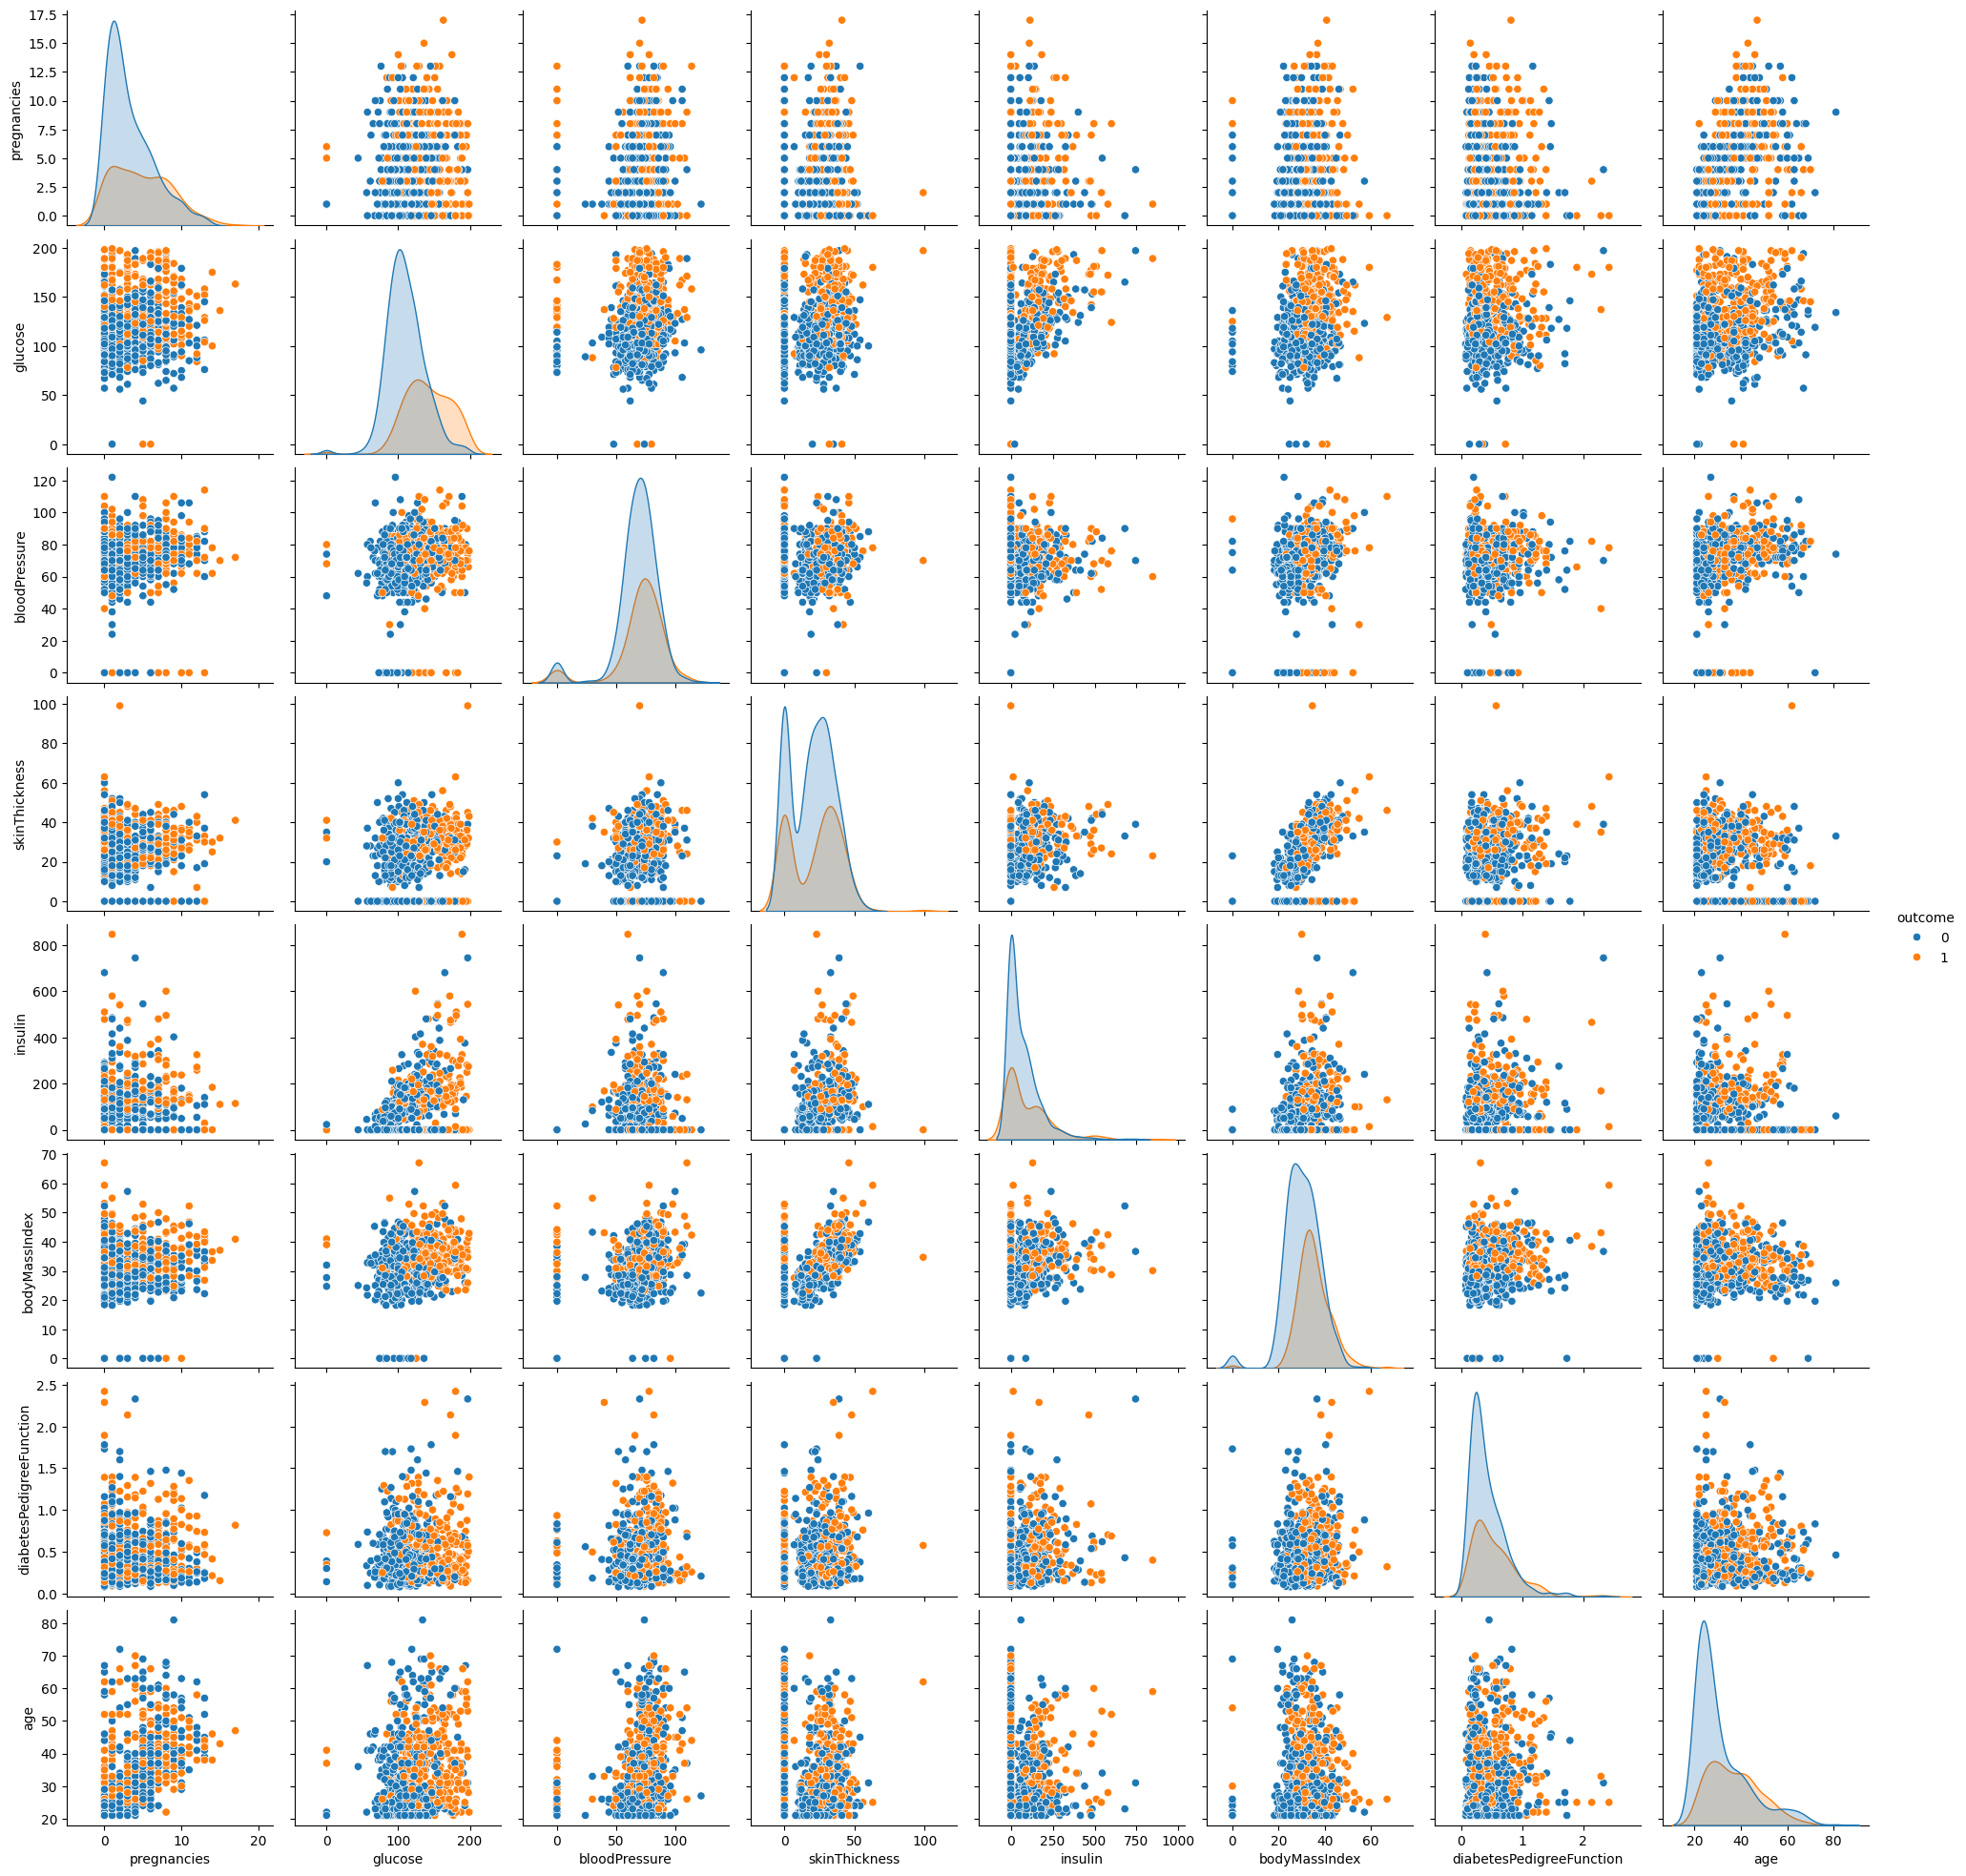

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the PySpark DataFrame to a Pandas DataFrame
pandas_df = df.select("*").toPandas()

# Create a pairplot using Seaborn
sns.pairplot(data=pandas_df, hue="outcome")

# Show the plot
plt.show()

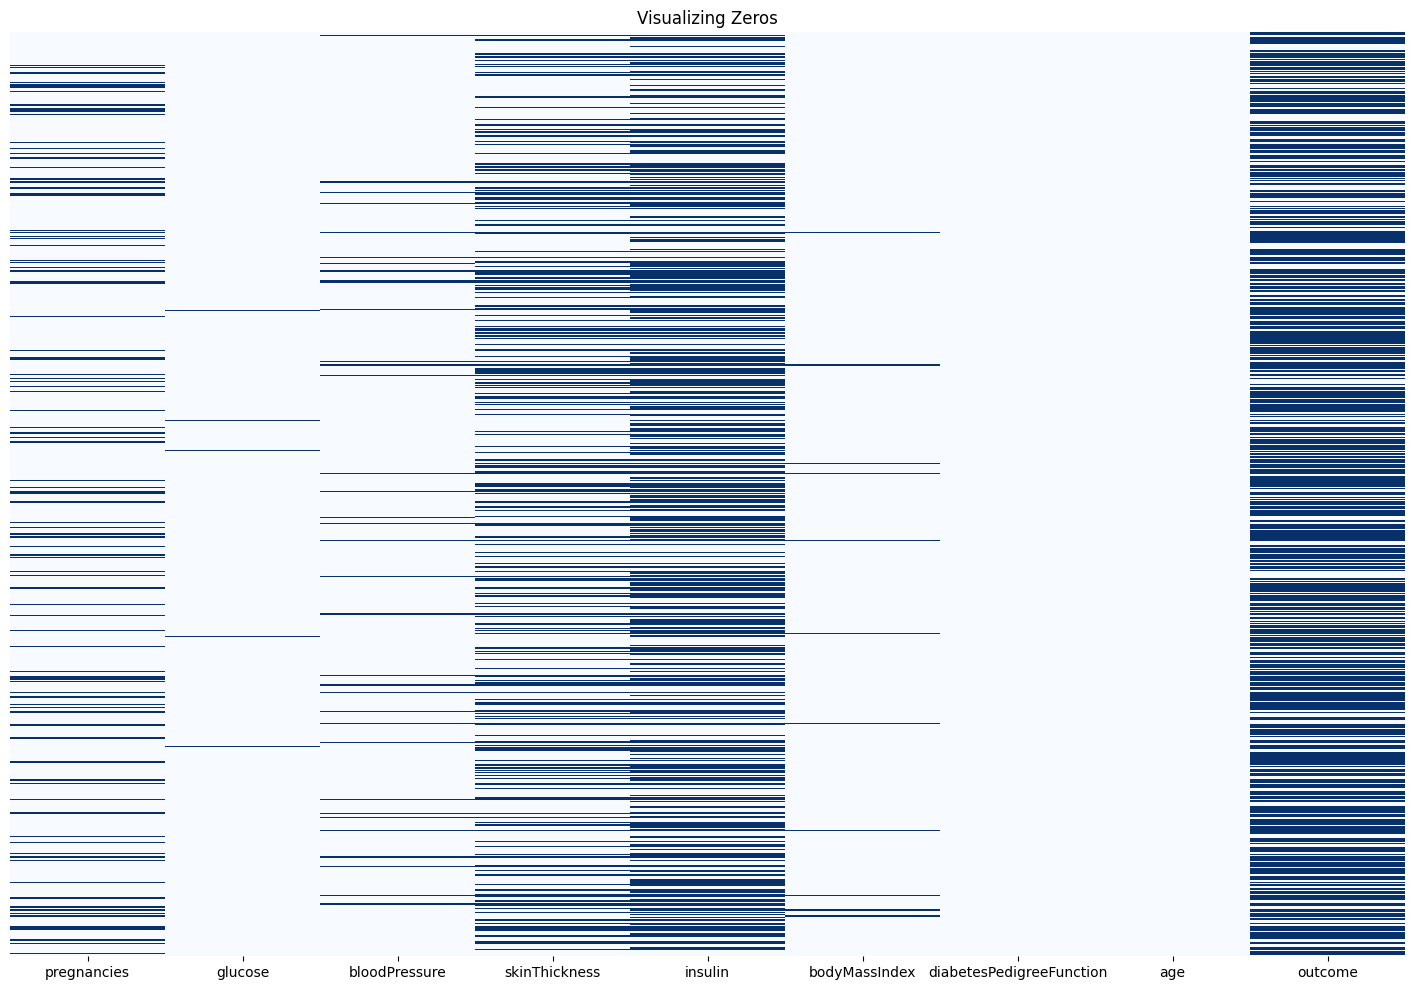

In [ ]:
# Visualizing zero values position in dataset
plt.figure(figsize=(18,12))
plt.title("Visualizing Zeros")
sns.heatmap(pandas_df==0, cbar=False, cmap='Blues', yticklabels=False);

In [ ]:
from pyspark.sql.functions import when, col, sum

# Compute the number of zeros in each column
zero_counts = df.agg(*[(sum(when(col(c) == 0, 1)).alias(c)) for c in df.columns])

# Display the results
zero_counts.show()

+-----------+-------+-------------+-------------+-------+-------------+------------------------+----+-------+
|pregnancies|glucose|bloodPressure|skinThickness|insulin|bodyMassIndex|diabetesPedigreeFunction| age|outcome|
+-----------+-------+-------------+-------------+-------+-------------+------------------------+----+-------+
|        111|      5|           35|          227|    374|           11|                    NULL|NULL|    500|
+-----------+-------+-------------+-------------+-------+-------------+------------------------+----+-------+



In [ ]:
# Filter out rows with zeros in the Glucose, BloodPressure, and BMI columns
df = df.filter((col("glucose") != 0) & (col("bloodPressure") != 0) & (col("bodyMassIndex") != 0))

# Show the resulting DataFrame
df.show()

+-----------+-------+-------------+-------------+-------+-------------+------------------------+---+-------+
|pregnancies|glucose|bloodPressure|skinThickness|insulin|bodyMassIndex|diabetesPedigreeFunction|age|outcome|
+-----------+-------+-------------+-------------+-------+-------------+------------------------+---+-------+
|          7|     81|           78|           40|     48|         46.7|                   0.261| 42|      0|
|          4|    197|           70|           39|    744|         36.7|                   2.329| 31|      0|
|          3|    170|           64|           37|    225|         34.5|                   0.356| 30|      1|
|          9|     72|           78|           25|      0|         31.6|                    0.28| 38|      0|
|          1|     99|           58|           10|      0|         25.4|                   0.551| 21|      0|
|          3|    128|           78|            0|      0|         21.1|                   0.268| 55|      0|
|          1|     7

In [ ]:
# Compute the number of zeros in each column
zero_counts = df.agg(*[(sum(when(col(c) == 0, 1)).alias(c)) for c in df.columns])

# Display the results
zero_counts.show()

print("Deleted rows: ",initial_shape[0]-df.count())

+-----------+-------+-------------+-------------+-------+-------------+------------------------+----+-------+
|pregnancies|glucose|bloodPressure|skinThickness|insulin|bodyMassIndex|diabetesPedigreeFunction| age|outcome|
+-----------+-------+-------------+-------------+-------+-------------+------------------------+----+-------+
|         99|   NULL|         NULL|          192|    332|         NULL|                    NULL|NULL|    475|
+-----------+-------+-------------+-------------+-------+-------------+------------------------+----+-------+

Deleted rows:  44


In [ ]:
# Replace zeros in Skin Thickness column for an average of the column
# Compute the average value of the SkinThickness column
from pyspark.sql.functions import mean

avg_skin_thickness = df.agg(mean(col("skinThickness"))).collect()[0][0]

# Replace zeros with the average value of the column
df = df.withColumn("skinThickness", when(col("skinThickness") == 0, avg_skin_thickness).otherwise(col("skinThickness")))

# Show the resulting DataFrame
df.show()

+-----------+-------+-------------+------------------+-------+-------------+------------------------+---+-------+
|pregnancies|glucose|bloodPressure|     skinThickness|insulin|bodyMassIndex|diabetesPedigreeFunction|age|outcome|
+-----------+-------+-------------+------------------+-------+-------------+------------------------+---+-------+
|          7|     81|           78|              40.0|     48|         46.7|                   0.261| 42|      0|
|          4|    197|           70|              39.0|    744|         36.7|                   2.329| 31|      0|
|          3|    170|           64|              37.0|    225|         34.5|                   0.356| 30|      1|
|          9|     72|           78|              25.0|      0|         31.6|                    0.28| 38|      0|
|          1|     99|           58|              10.0|      0|         25.4|                   0.551| 21|      0|
|          3|    128|           78|21.443370165745858|      0|         21.1|            

In [ ]:
from pyspark.sql.functions import corr

# Calculate the correlation between Glucose and Insulin
correlation = df.select(corr("glucose", "insulin")).collect()[0][0]

# Display the result
print("Correlation between Glucose and Insulin:", correlation*100,"%")

Correlation between Glucose and Insulin: 33.789641687178126 %


In [ ]:
# Drop the Insulin column
df = df.drop("insulin")

# Show the resulting DataFrame
df.show()

+-----------+-------+-------------+------------------+-------------+------------------------+---+-------+
|pregnancies|glucose|bloodPressure|     skinThickness|bodyMassIndex|diabetesPedigreeFunction|age|outcome|
+-----------+-------+-------------+------------------+-------------+------------------------+---+-------+
|          7|     81|           78|              40.0|         46.7|                   0.261| 42|      0|
|          4|    197|           70|              39.0|         36.7|                   2.329| 31|      0|
|          3|    170|           64|              37.0|         34.5|                   0.356| 30|      1|
|          9|     72|           78|              25.0|         31.6|                    0.28| 38|      0|
|          1|     99|           58|              10.0|         25.4|                   0.551| 21|      0|
|          3|    128|           78|21.443370165745858|         21.1|                   0.268| 55|      0|
|          1|     79|           60|           

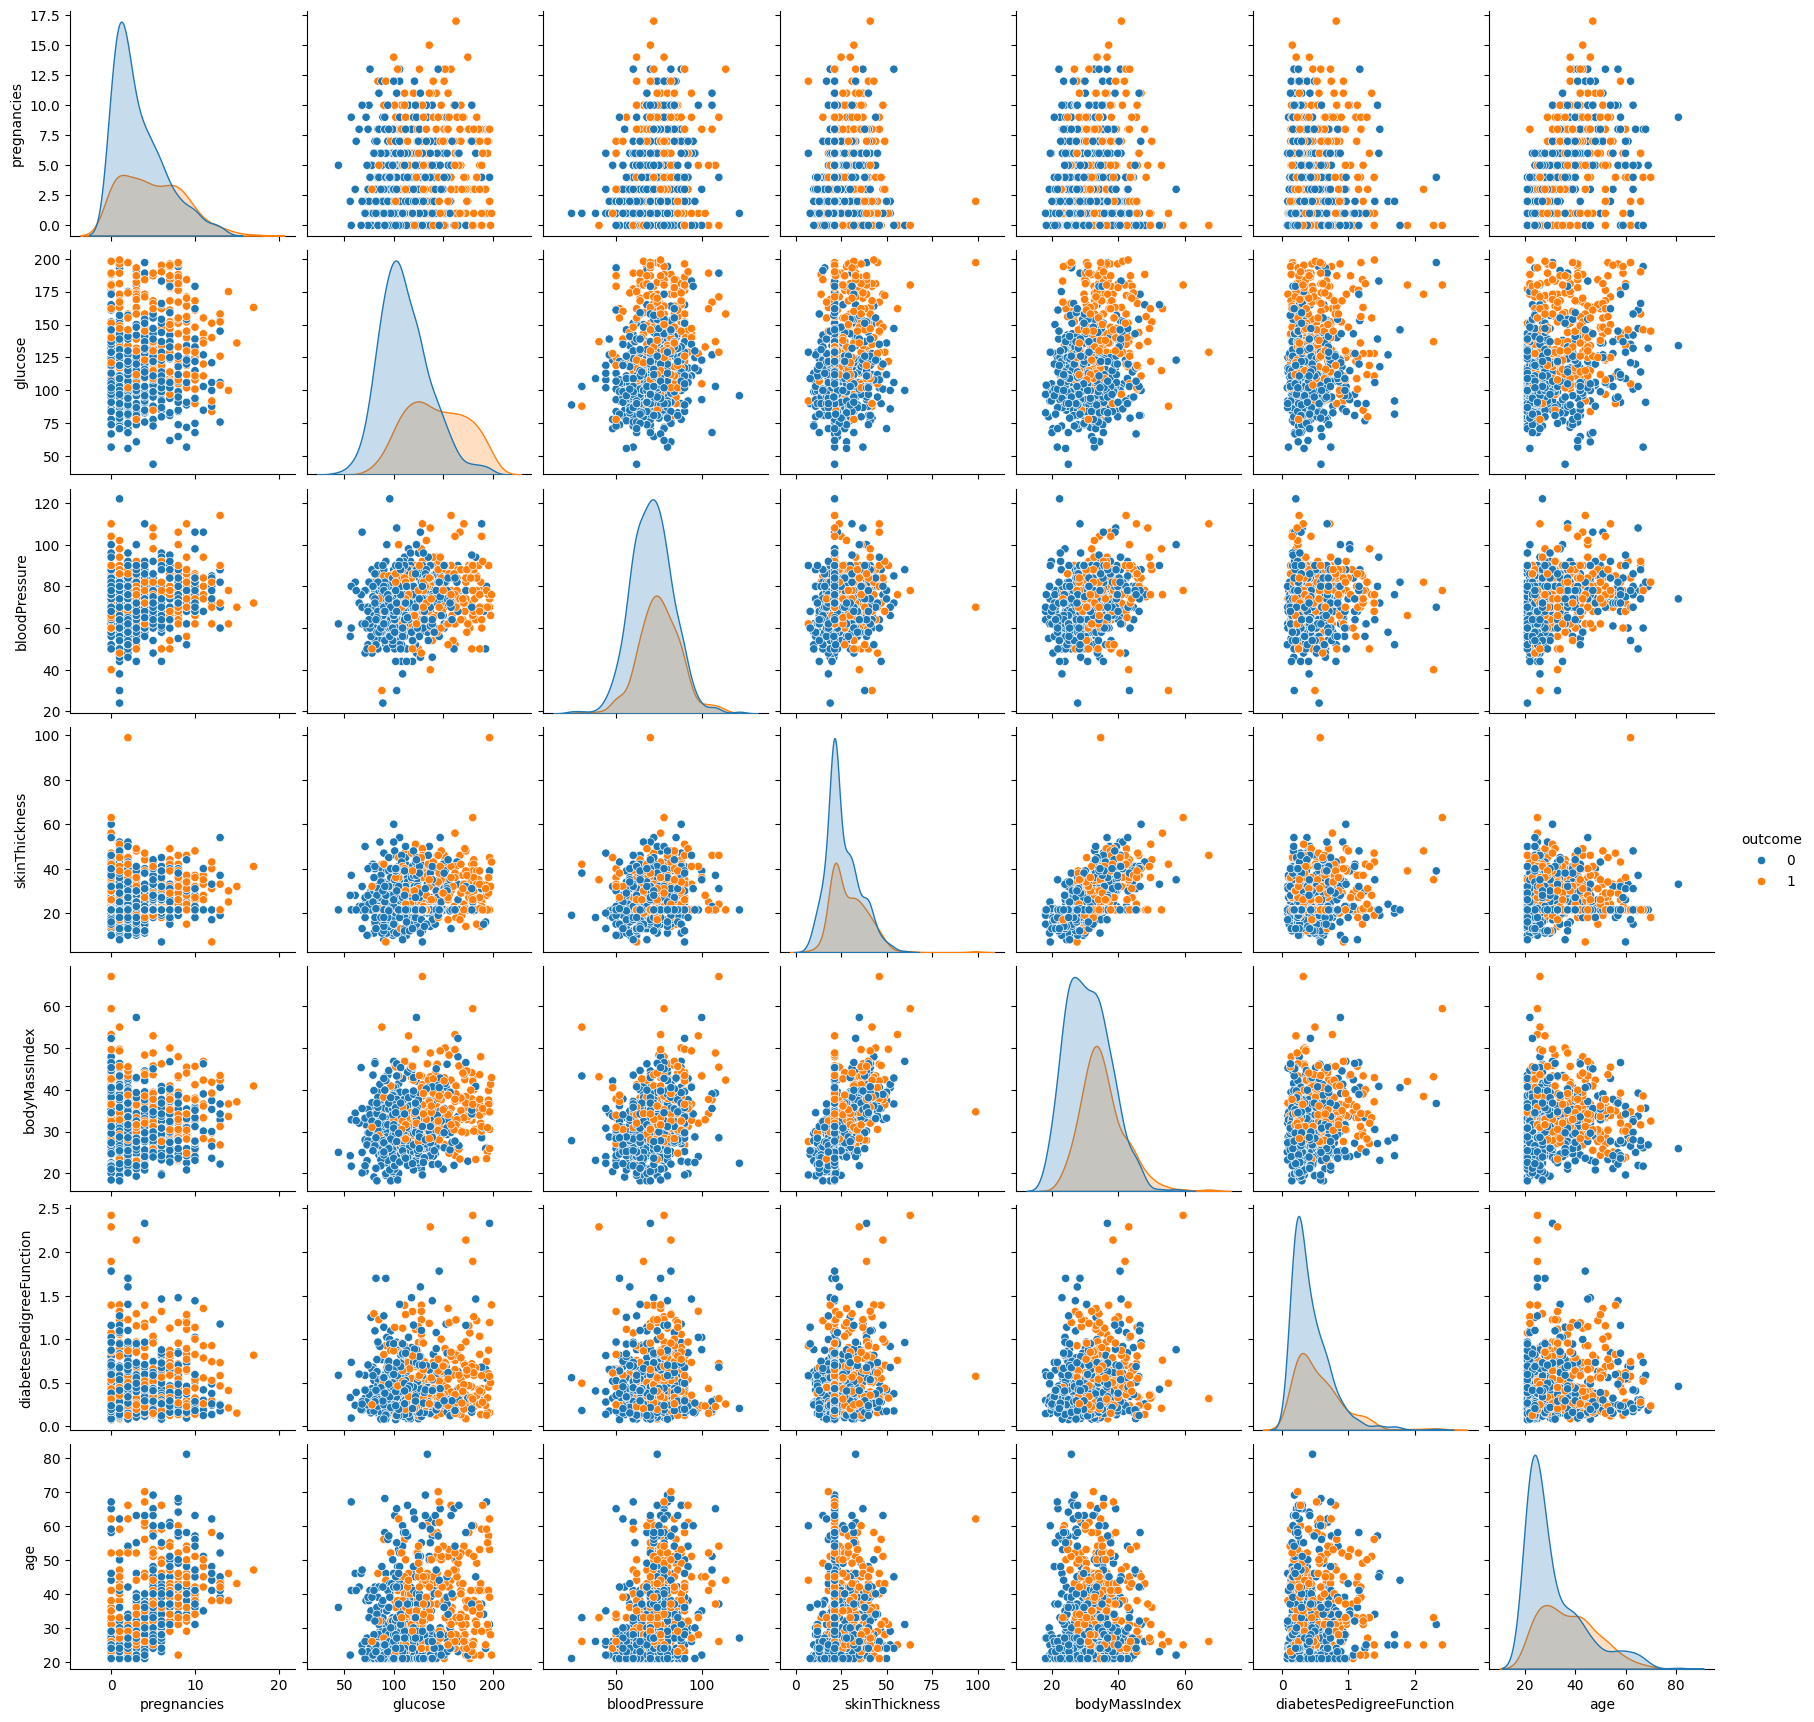

In [ ]:
# Convert the PySpark DataFrame to a Pandas DataFrame
pandas_df = df.select("*").toPandas()

# Create a pairplot using Seaborn
sns.pairplot(data=pandas_df, hue="outcome")

# Show the plot
plt.show()

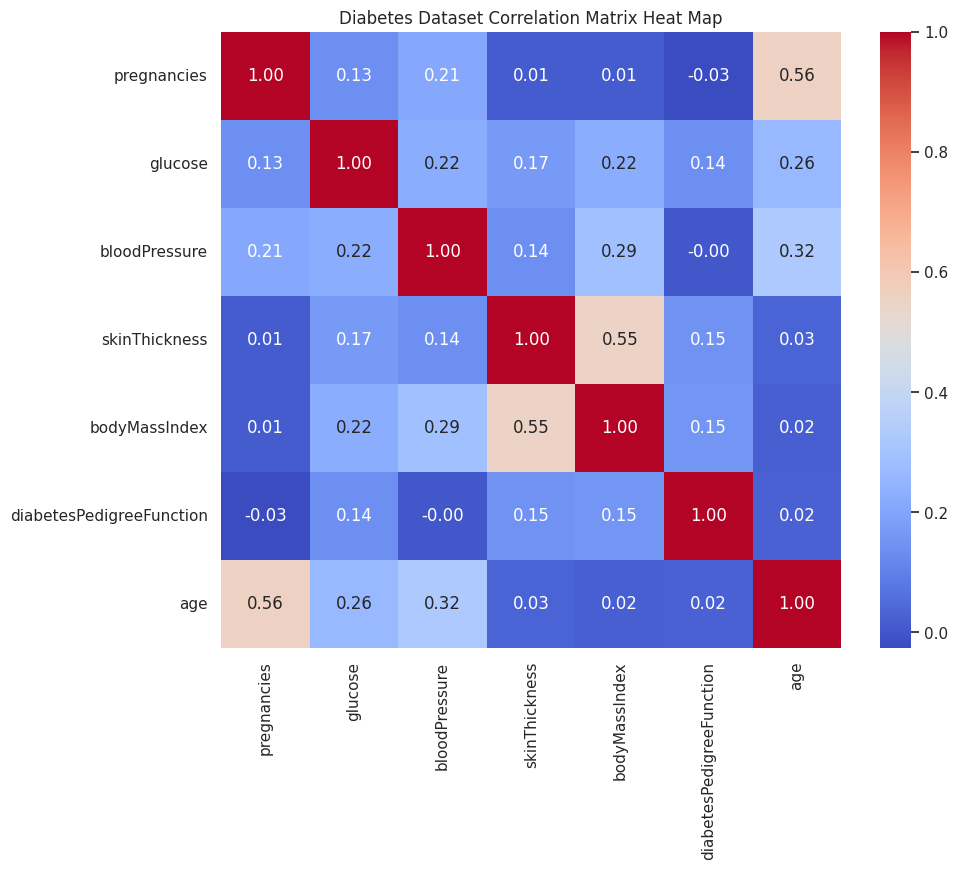

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import numpy as np

# Create a list of column names
columns = ["pregnancies", "glucose", "bloodPressure", "skinThickness", "bodyMassIndex", "diabetesPedigreeFunction", "age"]

# Combine numerical columns into a vector column
assembler = VectorAssembler(inputCols=columns, outputCol="features")
df_features = assembler.transform(df).select("features")

# Calculate correlation matrix
correlation_matrix = Correlation.corr(df_features, "features").head().asDict()["pearson({})".format("features")]

# Convert correlation matrix to numpy array
correlation_matrix_np = np.array(correlation_matrix.toArray())

# Create heat map using seaborn and matplotlib
sns.set(style="white")
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlation_matrix_np, annot=True, fmt=".2f", cmap="coolwarm", ax=ax, xticklabels=columns, yticklabels=columns)
ax.set_title("Diabetes Dataset Correlation Matrix Heat Map")
plt.show()

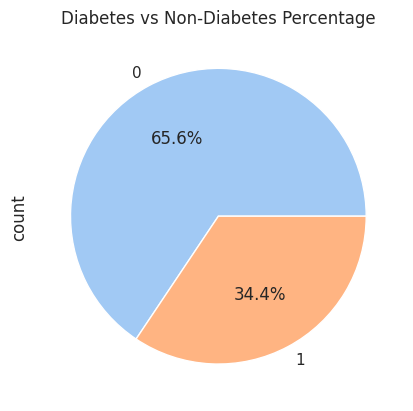

In [ ]:
# Convert the PySpark DataFrame to a Pandas DataFrame
pandas_df = df.select("*").toPandas()

sns.set_palette('pastel')
pandas_df['outcome'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Diabetes vs Non-Diabetes Percentage')
plt.show()

In [ ]:
# Checking the Balance
# Count the number of samples in each class
counts = df.groupBy("outcome").count().collect()
minority_class_count = min(counts, key=lambda x: x[1])[1]
majority_class_count = max(counts, key=lambda x: x[1])[1]

balanced=(majority_class_count-minority_class_count)/(majority_class_count+minority_class_count)<0.20

print(f"is the dataset balanced? {balanced}")

is the dataset balanced? False


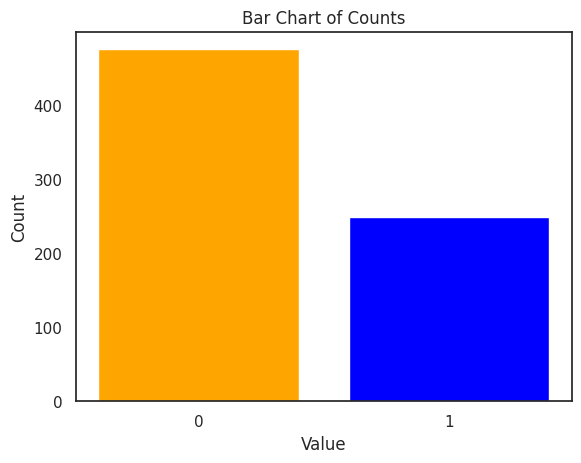

In [ ]:
# Define the counts and values for each bar
counts = [minority_class_count, majority_class_count]
values = [1,0]

# Define the colors for each bar
colors = ["blue", "orange"]

# Plot the bar chart
plt.bar(values, counts, color=colors)
plt.title("Bar Chart of Counts")
plt.xlabel("Value")
plt.ylabel("Count")

# Set the tick values for the x-axis
plt.xticks(values)

plt.show()

In [ ]:
(majority_class_count,minority_class_count)

(475, 249)

In [ ]:
# Compute the sampling fraction for the majority class
sampling_fraction = minority_class_count / majority_class_count

# Randomly sample from the majority class
majority_class_df = df.filter(col("outcome") == 0)
sampled_majority_class_df = majority_class_df.sampleBy("outcome", fractions={0: sampling_fraction}, seed=42)

# Combine the sampled majority class with the original minority class
df = df.filter(col("outcome") == 1).union(sampled_majority_class_df)

# Show the resulting DataFrame
df.show()

+-----------+-------+-------------+------------------+-------------+------------------------+---+-------+
|pregnancies|glucose|bloodPressure|     skinThickness|bodyMassIndex|diabetesPedigreeFunction|age|outcome|
+-----------+-------+-------------+------------------+-------------+------------------------+---+-------+
|          3|    170|           64|              37.0|         34.5|                   0.356| 30|      1|
|          8|    167|          106|              46.0|         37.6|                   0.165| 43|      1|
|          7|    103|           66|              32.0|         39.1|                   0.344| 31|      1|
|          1|     88|           30|              42.0|         55.0|                   0.496| 26|      1|
|         14|    100|           78|              25.0|         36.6|                   0.412| 46|      1|
|          9|    171|          110|              24.0|         45.4|                   0.721| 54|      1|
|          2|    155|           74|           

In [ ]:
shape(df)

(515, 8)

is the dataset balanced? True


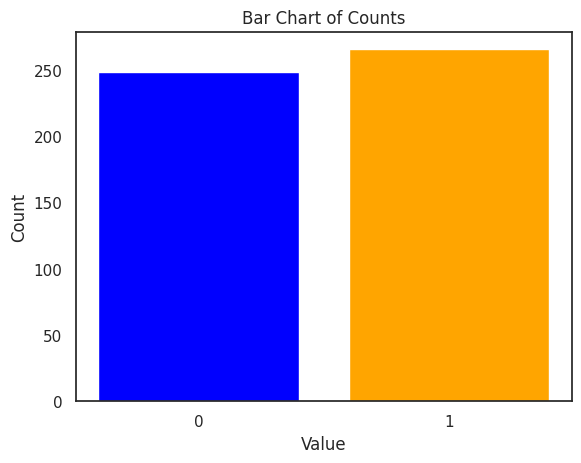

In [ ]:
# Count the number of samples in each class
counts = df.groupBy("outcome").count().collect()
minority_class_count = min(counts, key=lambda x: x[1])[1]
majority_class_count = max(counts, key=lambda x: x[1])[1]

balanced=(majority_class_count-minority_class_count)/(majority_class_count+minority_class_count)<0.20

print(f"is the dataset balanced? {balanced}")

import matplotlib.pyplot as plt

# Define the counts and values for each bar
counts = [minority_class_count, majority_class_count]
values = [0, 1]

# Define the colors for each bar
colors = ["blue", "orange"]

# Plot the bar chart
plt.bar(values, counts, color=colors)
plt.title("Bar Chart of Counts")
plt.xlabel("Value")
plt.ylabel("Count")

# Set the tick values for the x-axis
plt.xticks(values)

plt.show()

In [ ]:
(majority_class_count,minority_class_count)

(266, 249)

In [ ]:
# Scaling Features
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler

# Create a vector assembler for the input columns
input_cols = df.columns[:-1] # Exclude the last column, which is the label
assembler = VectorAssembler(inputCols=input_cols, outputCol="features")

# Assemble the input columns into a vector column
vector_df = assembler.transform(df)

# Scale the input columns using MinMaxScaler
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
scaled_df = scaler.fit(vector_df).transform(vector_df)

# Show the resulting DataFrame
scaled_df.show()

+-----------+-------+-------------+------------------+-------------+------------------------+---+-------+--------------------+--------------------+
|pregnancies|glucose|bloodPressure|     skinThickness|bodyMassIndex|diabetesPedigreeFunction|age|outcome|            features|      scaledFeatures|
+-----------+-------+-------------+------------------+-------------+------------------------+---+-------+--------------------+--------------------+
|          3|    170|           64|              37.0|         34.5|                   0.356| 30|      1|[3.0,170.0,64.0,3...|[0.17647058823529...|
|          8|    167|          106|              46.0|         37.6|                   0.165| 43|      1|[8.0,167.0,106.0,...|[0.47058823529411...|
|          7|    103|           66|              32.0|         39.1|                   0.344| 31|      1|[7.0,103.0,66.0,3...|[0.41176470588235...|
|          1|     88|           30|              42.0|         55.0|                   0.496| 26|      1|[1.0,88

# 3. Learning Model

In [ ]:
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

train_data, test_data = scaled_df.randomSplit([0.8, 0.2], seed=42)

# Random Forest Classifier
rf = RandomForestClassifier(featuresCol='scaledFeatures', labelCol='outcome', numTrees=10)
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)

rf_evaluator = MulticlassClassificationEvaluator(labelCol="outcome", predictionCol="prediction", metricName="accuracy")
rf_accuracy = rf_evaluator.evaluate(rf_predictions)

print(f"Random Forest Accuracy: {rf_accuracy}")

Random Forest Accuracy: 0.7857142857142857


In [ ]:
# Gradient-Boosted Tree Classifier
train_data, test_data = scaled_df.randomSplit([0.8, 0.2], seed=42)
gbt = GBTClassifier(featuresCol='scaledFeatures', labelCol='outcome', maxIter=10)

gbt_model = gbt.fit(train_data)
gbt_predictions = gbt_model.transform(test_data)

gbt_evaluator = MulticlassClassificationEvaluator(labelCol="outcome", predictionCol="prediction", metricName="accuracy")
gbt_accuracy = gbt_evaluator.evaluate(gbt_predictions)

print(f"Gradient-Boosted Trees Accuracy: {gbt_accuracy}")

Gradient-Boosted Trees Accuracy: 0.7142857142857143


In [ ]:
# Decision Tree
train_data, test_data = scaled_df.randomSplit([0.8, 0.2], seed=42)
dt = DecisionTreeClassifier(featuresCol='scaledFeatures', labelCol='outcome', maxDepth=3)

dt_model = dt.fit(train_data)
dt_predictions = dt_model.transform(test_data)

dt_evaluator = MulticlassClassificationEvaluator(labelCol="outcome", predictionCol="prediction", metricName="accuracy")
dt_accuracy = dt_evaluator.evaluate(dt_predictions)

print(f"Decision Tree Accuracy: {dt_accuracy}")

Decision Tree Accuracy: 0.7380952380952381


In [ ]:
# Logistic Regression
train_data, test_data = scaled_df.randomSplit([0.8, 0.2], seed=42)
lr = LogisticRegression(featuresCol='scaledFeatures', labelCol='outcome')

lrModel = lr.fit(train_data)
predictions = lrModel.transform(test_data)

evaluator = BinaryClassificationEvaluator(labelCol="outcome")
accuracy = evaluator.evaluate(predictions)

print(f"Accuracy: {accuracy}")

Accuracy: 0.8541666666666667


In [ ]:
# Comparing results with metrics
evaluators = {
    "accuracy": MulticlassClassificationEvaluator(labelCol="outcome", predictionCol="prediction", metricName="accuracy"),
    "f1": MulticlassClassificationEvaluator(labelCol="outcome", predictionCol="prediction", metricName="f1"),
    "weightedPrecision": MulticlassClassificationEvaluator(labelCol="outcome", predictionCol="prediction", metricName="weightedPrecision"),
    "weightedRecall": MulticlassClassificationEvaluator(labelCol="outcome", predictionCol="prediction", metricName="weightedRecall"),
}

def print_metrics(predictions, model_name):
    print(f"\n--- {model_name} Metrics ---")
    for metric_name, evaluator in evaluators.items():
      try:
        metric_value = evaluator.evaluate(predictions)
        print(f"{metric_name.replace('weighted','')}: {metric_value}")
      except:
        print(f"Cannot compute {metric_name} for this model.")

In [ ]:
print_metrics(rf_predictions, "Random Forest")


--- Random Forest Metrics ---
accuracy: 0.7857142857142857
f1: 0.7863304033516799
Precision: 0.7878391631252043
Recall: 0.7857142857142857


In [ ]:
print_metrics(gbt_predictions, "Gradient-Boosted Tree")


--- Gradient-Boosted Tree Metrics ---
accuracy: 0.7142857142857143
f1: 0.7142857142857143
Precision: 0.7440476190476191
Recall: 0.7142857142857143


In [ ]:
print_metrics(dt_predictions, "Decision Tree")


--- Decision Tree Metrics ---
accuracy: 0.7380952380952381
f1: 0.7388380196094321
Precision: 0.760706113108859
Recall: 0.7380952380952381


In [ ]:
# Logistic Regression Evaluation (Binary Classification)
binary_evaluator = BinaryClassificationEvaluator(labelCol="outcome", rawPredictionCol="rawPrediction")
lr_auc = binary_evaluator.evaluate(predictions, {binary_evaluator.metricName: "areaUnderROC"})
print("\n--- Logistic Regression Metrics ---")
print(f"AUC: {lr_auc}")

for metric_name, evaluator in evaluators.items():
    try:
        metric_value = evaluator.evaluate(predictions)
        print(f"{metric_name.replace('weighted','')}: {metric_value}")
    except:
        print(f"Cannot compute {metric_name} for this model.")


--- Logistic Regression Metrics ---
AUC: 0.8541666666666667
accuracy: 0.7738095238095238
f1: 0.7709683548312188
Precision: 0.7738457525432572
Recall: 0.7738095238095237


# 4. Hyperparameter Tuning

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Hyperparameter Tuning for Decision Tree
paramGrid_dt = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [2, 3, 4, 5])
             .addGrid(dt.minInstancesPerNode, [1, 2, 4])
             .build())

crossval_dt = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid_dt,
                          evaluator=MulticlassClassificationEvaluator(labelCol="outcome", predictionCol="prediction", metricName="accuracy"),
                          numFolds=3)

cvModel_dt = crossval_dt.fit(train_data)
dt_predictions_tuned = cvModel_dt.transform(test_data)

dt_accuracy_tuned = dt_evaluator.evaluate(dt_predictions_tuned)
print(f"Tuned Decision Tree Accuracy: {dt_accuracy_tuned}")
print_metrics(dt_predictions_tuned, "Tuned Decision Tree")

Tuned Decision Tree Accuracy: 0.7023809523809523

--- Tuned Decision Tree Metrics ---
accuracy: 0.7023809523809523
f1: 0.7028530229683798
Precision: 0.7035241928858951
Recall: 0.7023809523809523


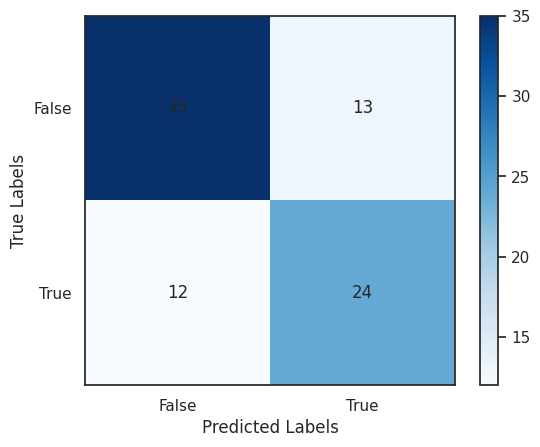

In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

# Selection
predictionAndTarget = dt_predictions_tuned.select("outcome", "prediction")
predictionAndTargetNumpy = np.array((predictionAndTarget.collect()))

c_matrix_dt = confusion_matrix(predictionAndTargetNumpy[:,0], predictionAndTargetNumpy[:,1])

# Create a heatmap of the confusion matrix
plt.imshow(c_matrix_dt, cmap=plt.cm.Blues)

# Set the x-axis and y-axis labels
plt.xticks([0, 1], ['False', 'True'])
plt.yticks([0, 1], ['False', 'True'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Add a color bar to show the scale of the values
plt.colorbar()

# Add the values to the heatmap
for i in range(c_matrix_dt.shape[0]):
    for j in range(c_matrix_dt.shape[1]):
        plt.text(j, i, c_matrix_dt[i, j], ha='center', va='center')

# Show the plot
plt.show()

In [ ]:
# Hyperparameter Tuning for Logistic Regression
paramGrid_lr = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.1, 1.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .build())

crossval_lr = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid_lr,
                          evaluator=BinaryClassificationEvaluator(labelCol="outcome"),
                          numFolds=3)

cvModel_lr = crossval_lr.fit(train_data)
lr_predictions_tuned = cvModel_lr.transform(test_data)

lr_auc_tuned = binary_evaluator.evaluate(lr_predictions_tuned, {binary_evaluator.metricName: "areaUnderROC"})
print("\n--- Tuned Logistic Regression Metrics ---")
print(f"AUC: {lr_auc_tuned}")

print_metrics(lr_predictions_tuned, "Tuned Logistic Regression")


--- Tuned Logistic Regression Metrics ---
AUC: 0.8559027777777779

--- Tuned Logistic Regression Metrics ---
accuracy: 0.7619047619047619
f1: 0.7596638655462186
Precision: 0.7609890109890111
Recall: 0.7619047619047619


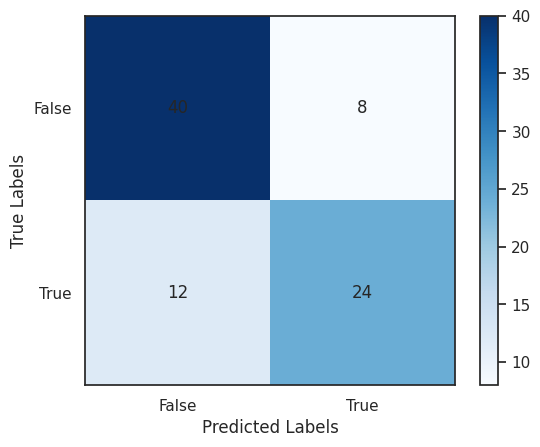

In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

# Selection
predictionAndTarget = lr_predictions_tuned.select("outcome", "prediction")
predictionAndTargetNumpy = np.array((predictionAndTarget.collect()))

c_matrix_lr = confusion_matrix(predictionAndTargetNumpy[:,0], predictionAndTargetNumpy[:,1])

# Create a heatmap of the confusion matrix
plt.imshow(c_matrix_lr, cmap=plt.cm.Blues)

# Set the x-axis and y-axis labels
plt.xticks([0, 1], ['False', 'True'])
plt.yticks([0, 1], ['False', 'True'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Add a color bar to show the scale of the values
plt.colorbar()

# Add the values to the heatmap
for i in range(c_matrix_lr.shape[0]):
    for j in range(c_matrix_lr.shape[1]):
        plt.text(j, i, c_matrix_lr[i, j], ha='center', va='center')

# Show the plot
plt.show()

# 5. Testing Data

In [ ]:
from pyspark.ml.feature import VectorAssembler, MinMaxScaler

# Function for prediction
def predict_diabetes(features):
    assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
    features_df = spark.createDataFrame([features], input_cols)
    features_df = assembler.transform(features_df)

    # Get the fitted MinMaxScalerModel from the scaler object
    scaler_model = scaler.fit(features_df)
    features_df = scaler_model.transform(features_df)

    # Make predictions using the trained model
    prediction = cvModel_lr.transform(features_df)

    # Extract the prediction
    predicted_outcome = prediction.select("prediction").collect()[0][0]

    return predicted_outcome

In [ ]:
example_features = [6, 148, 72, 35, 0, 33.6, 0.627, 50, 1] # Replace with actual feature values
predicted_class = predict_diabetes(example_features)

print(f"Klasifikasi kelas (0 tidak terkena diabetes, 1 terkena diabetes): {predicted_class}")

Klasifikasi kelas (0 tidak terkena diabetes, 1 terkena diabetes): 1.0
